## Let's do some imports first ##

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter
import glob
import pickle
from datetime import datetime
from tqdm import tqdm

## Now we want to load the dataset 

What we are interested in here is the SBP and Threshold Crossings Values 

In [ ]:
def load_channel_population_data(data):
    
    # Check if data is a tuple and extract the dictionary if necessary
    if isinstance(data, tuple):
        if data[0] is None and isinstance(data[1], dict):
            data = data[1]
        elif isinstance(data[0], dict):
            data = data[0]
        else:
            print(f"Unexpected data structure: {type(data)}")
            return None

    # Extract relevant data
    # population_data_dict = {}
    # population_data_dict['finger_kinematics'] = data['finger_kinematics']
    # population_data_dict["spiking_band_power"] = data['sbp']
    # population_data_dict["threshold_crossings"] = data["tcfr"]
    # population_data_dict["target_style"] = data['target_style']
    # population_data_dict['target_positions'] = data["target_positions"]

    # return population_data_dict
    return data

In [3]:
### LOAD AND PREPROCESS DATA ###

# Approximate total number of datasets
total_datasets = 384

# Create a progress bar
pbar = tqdm(total=total_datasets, desc="Processing datasets")

# Path to the folder containing pkl files (FIND THIS IN HISHAMS STUDENT FOLDER -> BIG DATASET -> AUTOTRIMMING AND PREPROCESSING)
data_folder = '../../Hisham_Temmar/big_dataset/2_autotrimming_and_preprocessing/preprocessing_092024_no7822nofalcon'

# Get list of pkl files
pkl_files = sorted(glob.glob(os.path.join(data_folder, '*.pkl')))

print(len(pkl_files))

# Dictionary to store results
results = {}

# Process each pkl file
counter = 0
for i in range(0, 384, 1): # range(0, 384, 25):
    file = pkl_files[i]

    # Extract date from filename (assuming format like 'YYYY-MM-DD_data.pkl')
    date = pd.to_datetime(os.path.basename(file).split('_')[0])

    # Load data
    with open(file, 'rb') as f:
        data = pickle.load(f)
        
    # Compute channel tuning
    try:
        population_data = load_channel_population_data(data)
        if population_data is not None:
            results[date] = population_data
    except Exception as e:
        print(f"Error processing file {file}: {str(e)}")
        continue

    # Update the progress bar
    pbar.update(1)
    
    # Store results
    results[date] = population_data

    counter += 1
    if counter == 384:
        break

# Close the progress bar
pbar.close()

Processing datasets:   0%|          | 0/384 [00:00<?, ?it/s]

385


Processing datasets: 100%|██████████| 384/384 [37:57<00:00,  5.93s/it] 


## Now let's prepare the data for visualization ##

In [4]:
### PREPARE DATA FOR VISUALIZATION ###
def prepare_tuning_data(results):
    # Create lists to store data
    dates = []
    kinematics = []
    threshold_crossings = []
    sbps = []
    tcfrs = []
    target_styles = []
    target_positions = []
    trial_indices = []
    trial_counts = []

    for date, pop_data in results.items():
        print(date)
        dates.append(date)
        kinematics.append(pop_data['finger_kinematics'])
        threshold_crossings.append(pop_data['tcfr'])
        sbps.append(pop_data['sbp'])
        tcfrs.append(pop_data['tcfr'])
        target_styles.append(pop_data['target_style'])
        target_positions.append(pop_data['target_positions'])
        trial_indices.append(pop_data['trial_index'])
        trial_counts.append(pop_data['trial_count'])


    
    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'sbps': sbps,
        'tcfr': tcfrs,
        'threshold_crossings': threshold_crossings,
        'finger_kinematics': kinematics,
        'target_styles': target_styles,
        'target_positions': target_positions,
        'trial_counts': trial_counts,
        'trial_indices': trial_indices
    })
    
    df.set_index('date', inplace=True)

    return df

# Convert results to organized DataFrame
df_tuning = prepare_tuning_data(results)
df_tuning = df_tuning  #[:407] # remove 2024 (unstable) data


2020-01-27 00:00:00
2020-01-30 00:00:00
2020-02-04 00:00:00
2020-02-05 00:00:00
2020-02-06 00:00:00
2020-02-22 00:00:00
2020-02-24 00:00:00
2020-02-25 00:00:00
2020-02-28 00:00:00
2020-03-02 00:00:00
2020-03-10 00:00:00
2020-03-12 00:00:00
2020-03-13 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-06-24 00:00:00
2020-06-26 00:00:00
2020-07-08 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00
2020-07-31 00:00:00
2020-08-04 00:00:00
2020-08-08 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-22 00:00:00
2020-08-24 00:00:00
2020-08-26 00:00:00
2020-08-27 00:00:00
2020-08-28 00:00:00
2020-08-29 00:00:00
2020-08-31 00:00:00
2020-09-04 00:00:00
2020-09-05 00:00:00
2020-09-06 00:00:00
2020-09-07 00:00:00
2020-09-12 00:00:00
2020-09-16 00:00:00
2020-09-18 00:00:00
2020-09-19 00:00:00
2020-09-21 00:00:00
2020-09-22 00:00:00
2020-09-23 00:00:00
2020-09-24 00:00:00
2020-09-28 00:00:00
2020-09-29 00:00:00
2020-10-02 00:00:00
2020-10-07 00:00:00


## Lets look at some dimensionality of our data.

First, we want to calculate how the components needed to explain 80% of the variance (using PCA) changes over time. To do this, we first need to do PCA and calculate the cumulative variance over time.

In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


# Extract sbps data
sbps_data = np.array(df_tuning['sbps'].tolist(), dtype=object)
# Initialize lists to store results
dates = df_tuning.index
explained_variance_ratios = []
num_components_80_variance = []

# Perform PCA day-to-day
for day_data in sbps_data:
    pca = PCA()
    pca.fit(day_data)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    num_components = np.argmax(cumulative_variance >= 0.8) + 1
    
    explained_variance_ratios.append(pca.explained_variance_ratio_)
    num_components_80_variance.append(num_components)

# Store results in DataFrame
pca_results = pd.DataFrame({
    'date': dates,
    'num_components_80_variance': num_components_80_variance,
    'explained_variance_ratios': explained_variance_ratios
})


Now,lets plot and see what we get. You'll notice that the components decrease when the data was weird (summer of 2022), but the general trend is a slight increase over time (though there does seem to be more variance as time goes on as well)

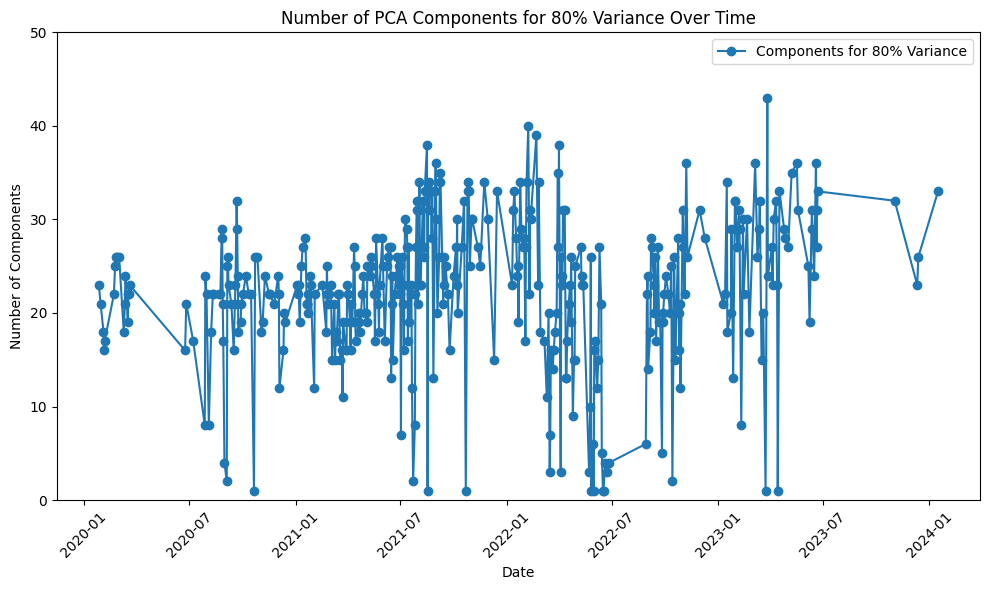

In [6]:
import matplotlib.pyplot as plt

# Plot 1: Number of components needed for 80% variance
plt.figure(figsize=(10, 6))
plt.plot(pca_results['date'], pca_results['num_components_80_variance'], 
         marker='o', label='Components for 80% Variance')
plt.xlabel('Date')
plt.ylabel('Number of Components')
plt.title('Number of PCA Components for 80% Variance Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.ylim(0,50)
plt.show()


Another way of looking at the same data is to break it down into quarters and visualize it on different axes. The same patterns hold here though (as it is the same data). It does seem easier to see here that while over time there is a slight increase in # of components needed for 80%, its not that drastic. 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skle

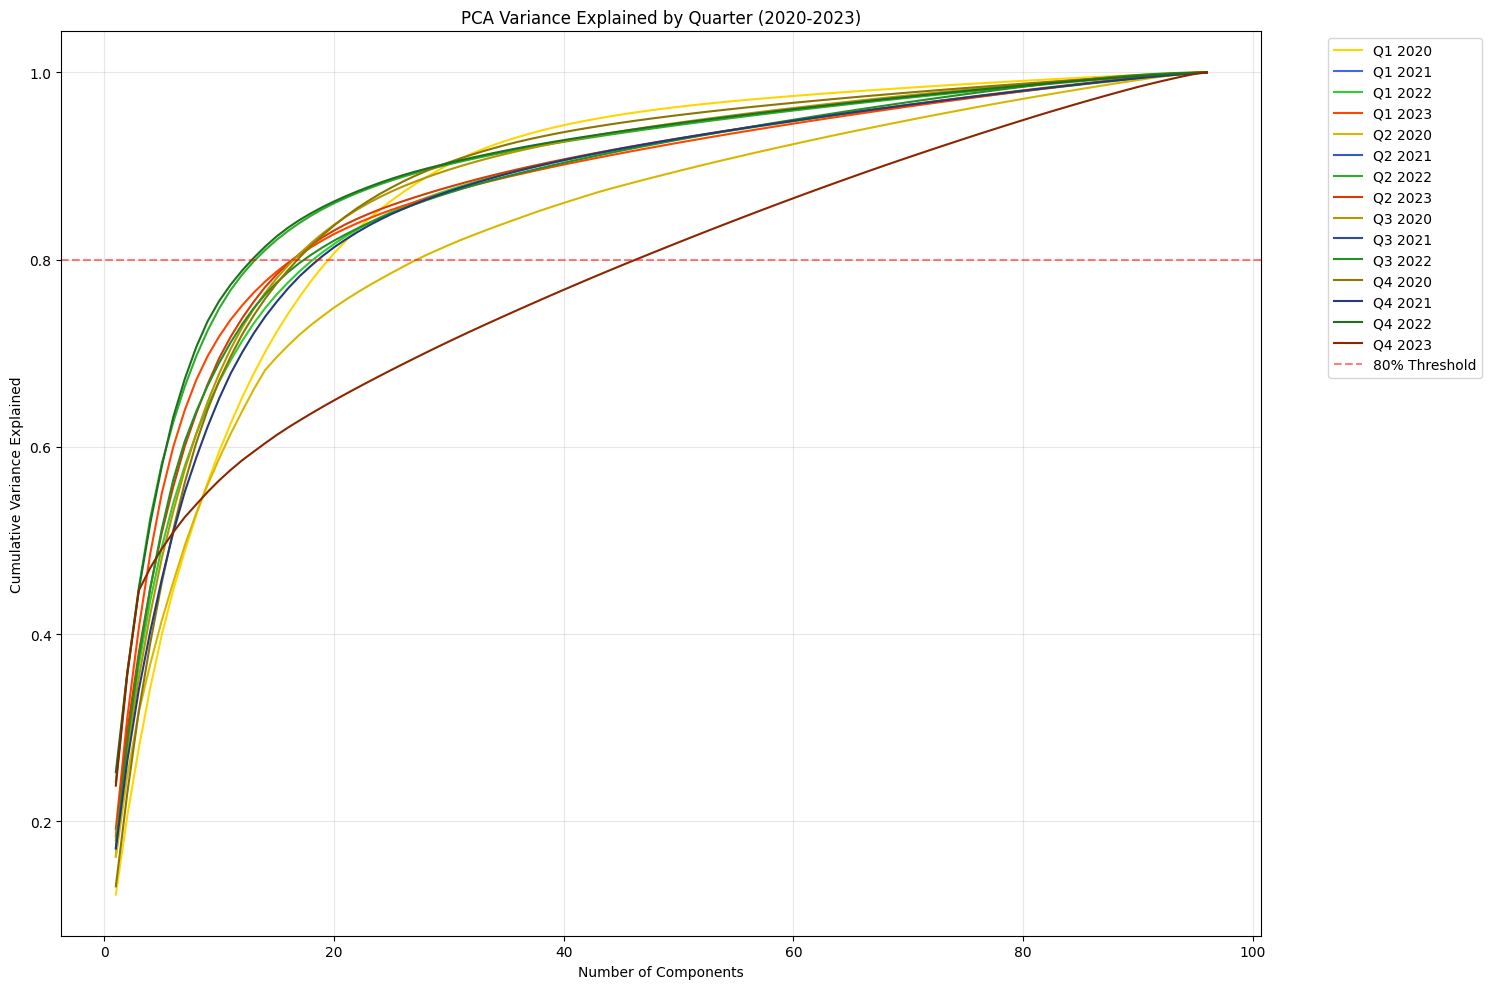

In [8]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Extract sbps data
sbps_data = np.array(df_tuning['tcfr'].tolist(), dtype=object)
dates = df_tuning.index

# Create quarter labels
dates = pd.to_datetime(dates)
quarters = pd.PeriodIndex(dates, freq='Q').quarter
years = pd.PeriodIndex(dates, freq='Q').year
quarter_labels = [f'Q{q} {y}' for q, y in zip(quarters, years)]

# Group data by quarters
quarter_groups = pd.DataFrame({
    'data': sbps_data.tolist(),
    'quarter_label': quarter_labels
}).groupby('quarter_label')

# Set up the plot
plt.figure(figsize=(15, 10))

# Define base colors for each year
year_colors = {
    2020: '#FFD700',  # Gold/Yellow
    2021: '#4169E1',  # Royal Blue
    2022: '#32CD32',  # Lime Green
    2023: '#FF4500'   # Orange Red
}

# Create color variations for quarters within each year
def get_quarter_color(year, quarter, base_color):
    base_rgb = mcolors.to_rgb(base_color)
    # Darken the color progressively for each quarter
    factor = 1 - (quarter - 1) * 0.15
    return tuple(min(1, c * factor) for c in base_rgb)

# Process each quarter
for quarter_label, group in quarter_groups:
    year = int(quarter_label.split()[-1])
    quarter = int(quarter_label[1])
    
    # Get the color for this quarter
    if year == 2024:
        continue
    
    quarter_color = get_quarter_color(year, quarter, year_colors[year])
    
    # Get the first day's data to determine number of features
    sample_data = group['data'].iloc[0]
    n_features = sample_data.shape[1]
    
    # Calculate average variance explained for the quarter
    quarter_variance = np.zeros(n_features)
    count = 0
    
    for day_data in group['data']:
        pca = PCA()
        pca.fit(day_data)
        quarter_variance += np.cumsum(pca.explained_variance_ratio_)
        count += 1
    
    # Calculate average
    avg_quarter_variance = quarter_variance / count
    
    # Plot the line for this quarter
    plt.plot(range(1, n_features + 1), avg_quarter_variance, 
             label=quarter_label, color=quarter_color)

# Add the 80% threshold line
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='80% Threshold')

# Customize the plot
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA Variance Explained by Quarter (2020-2023)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()


### PCA of Reach Directions

One other cool thing we can do is take a look at our Center Out (CO) tasks, and look at how the dimensionality of the reach directions is changing with time

In [17]:
# IMPORTS
from sklearn.decomposition import PCA
#from movement_start_finder import find_kinematic_spikes
import jPCA
from jPCA.util import plot_projections
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
def direction_map(all_directions=False): 
    ''' 
    First step is to define the reach directions and mapping from coords to directions that we are looking for
    '''

    dir_list = None
    position_map = None

    if not all_directions:
        dir_list = ['N', 'W', 'E', 'S', 'NW', 'NE', 'SW', 'SE']
        position_map = {
            (0.5, 0.7): 'N', (0.5, 0.9): 'N',
            (0.5, 0.1): 'S', (0.5, 0.3): 'S',
            (0.7, 0.5): 'E', (0.9, 0.5): 'E',
            (0.1, 0.5): 'W', (0.3, 0.5): 'W',
            (0.7, 0.7): 'NE', (0.7, 0.9): 'NE',
            (0.9, 0.7): 'NE', (0.9, 0.9): 'NE',
            (0.1, 0.7): 'NW', (0.1, 0.9): 'NW',
            (0.3, 0.7): 'NW', (0.3, 0.9): 'NW',
            (0.7, 0.1): 'SE', (0.7, 0.3): 'SE',
            (0.9, 0.1): 'SE', (0.9, 0.3): 'SE',
            (0.1, 0.1): 'SW', (0.1, 0.3): 'SW',
            (0.3, 0.1): 'SW', (0.3, 0.3): 'SW'
        }
    else:
        dir_list = ['N', 'W', 'E', 'S', 'NW1', 'NW2', 'NW3', 'NW4', 'NE1', 'NE2', 'NE3', 'NE4', 'SW1','SW2','SW3','SW4', 'SE1','SE2','SE3','SE4']
        position_map = {
            (0.5, 0.7): 'N', (0.5, 0.9): 'N',
            (0.5, 0.1): 'S', (0.5, 0.3): 'S',
            (0.7, 0.5): 'E', (0.9, 0.5): 'E',
            (0.1, 0.5): 'W', (0.3, 0.5): 'W',
            (0.7, 0.7): 'NE1', (0.7, 0.9): 'NE2',
            (0.9, 0.7): 'NE3', (0.9, 0.9): 'NE4',
            (0.1, 0.7): 'NW1', (0.1, 0.9): 'NW2',
            (0.3, 0.7): 'NW3', (0.3, 0.9): 'NW4',
            (0.7, 0.1): 'SE1', (0.7, 0.3): 'SE2',
            (0.9, 0.1): 'SE3', (0.9, 0.3): 'SE4',
            (0.1, 0.1): 'SW1', (0.1, 0.3): 'SW2',
            (0.3, 0.1): 'SW3', (0.3, 0.3): 'SW4'
        }

    
    return dir_list, position_map

In [6]:

from scipy.ndimage import gaussian_filter1d

def trim_neural_data_at_movement_onset_std_and_smooth(data_dict, std_multiplier=2, sigma=5, display_alignment=False):
    """
    Trims neural data using standard deviations above baseline mean, then smooths using Gaussian kernel
    
    Parameters:
    - data_dict: Dictionary containing neural data organized by year, and target position
    - std_multiplier: Number of standard deviations above baseline mean (default: 2)
    - sigma: Standard deviation for Gaussian kernel (in units of samples)
    - display_alignment: flag that specifies whether to visualize kinematic alignment
    
    Returns:
    - Dictionary with trimmed and smoothed neural data maintaining the same structure
    """
    trimmed_data = {}
    kin_data = {}
    
    for year in data_dict:
        trimmed_data[year] = {}
        kin_data[year] = {}
        
        
        for target_pos in data_dict[year]:

            if display_alignment:
                fig, ax = plt.subplots(figsize=(8, 4))

            for trial_data, kinematics in data_dict[year][target_pos]:

                
                # Use first 10% of trial kinematics as baseline
                baseline_period = kinematics[:int(kinematics.shape[0] * 0.1)]
                baseline_mean = np.mean(baseline_period)
                baseline_std = np.std(baseline_period)

                # Calculate threshold
                threshold = baseline_mean + (baseline_std * std_multiplier)
                min_threshold = baseline_mean - (baseline_std * std_multiplier)

                
                # Find first index where SBP exceeds threshold
                movement_onset_idx = next(
                    (i for i, value in enumerate(kinematics) if ((value > threshold) or (value < min_threshold))),
                    0
                )
                
                # Trim the data to start from movement onset and smooth it 
                pre_movement_start = movement_onset_idx-(150 // 20) # want 150 ms pre movement and 20 ms bins 
                post_movement_end = movement_onset_idx + (600 // 20) # want 600 ms post movement and 20 ms bins 


                if pre_movement_start < 0: # (drop trials where movement onset seems too close to start or too close to end)
                    continue
                if post_movement_end > trial_data.shape[0]-1:
                    continue

                smoothed_trial = gaussian_filter1d(trial_data[pre_movement_start:post_movement_end, :], sigma=1)

                if display_alignment:
                    time = np.arange(len(kinematics[pre_movement_start:post_movement_end]))
                    ax.plot(time, kinematics[pre_movement_start:post_movement_end])
                
                if target_pos not in trimmed_data[year]:
                    trimmed_data[year][target_pos] = [smoothed_trial]
                    kin_data[year][target_pos] =  [kinematics[pre_movement_start:post_movement_end]]
                else:
                    trimmed_data[year][target_pos].append(smoothed_trial)
                    kin_data[year][target_pos].append(kinematics[pre_movement_start:post_movement_end])
    
            if display_alignment:
                ax.set_xlabel("Bins")
                ax.set_ylabel("Value")
                ax.set_title(f"Kinematics Over Time for Target {target_pos} (Year {year})")
                ax.grid(True)
                plt.show()
    
    return trimmed_data,  kin_data



In [ ]:
def calculate_pca_and_split(df_yearly, time_periods, position_map, type_of_data, jpca=False):
    '''
    Calculates PCA on all data and splits the trials up using that data

        Params: df_yearly: dataframe that contains all the relevant data
                time_periods: list containing years we want to look at
                position_map: hash_map that maps target direction coordinates to the compass direction, so that its possible to group by target direction
                type_of_data: str that specifies SBPs vs TCFR
                jpca: flag indicating whether to do JPCA or PCA (not done yet)
        
        Returns: neural_data_for_direction: hashmap containing grouped neural PCA data; indexed by year, and target_pos
                 pca_results: hash_map containing pca results, indexed by each year
    '''


    # Now we will begin to Calculate neural trajectories with PCA 
    neural_data_for_direction = {
        2020: {},
        2021: {},
        2022: {},
        2023: {}
    }
    #neural_data_for_direction = {period: {} for period in time_periods}

    

    # initialize PCA storage for ALL data
    n_components = 3
    pca_results = {year: [] for year in neural_data_for_direction.keys()}
    #pca_results = {period: [] for period in time_periods}


    #Collect all sbps data across years and trials (that are CO)
    all_sbps = []
    for year in time_periods:
        year_group = df_yearly.get_group(year)
        for _, yearly_data in year_group.iterrows():
            if yearly_data["target_styles"] == "CO":
                all_sbps.append(yearly_data[type_of_data])

    # all_sbps = []
    # for period in time_periods:
    #     month_group = df_yearly[period] #.get_group(period)
    #     for _, monthly_data in month_group.iterrows():
    #         if monthly_data["target_styles"] == "CO":
    #             all_sbps.append(monthly_data[type_of_data])
                
    # Stack into matrix (n_samples × n_features)
    global_data = np.vstack(all_sbps)  # Shape: (total_trials*timepoints, n_channels)

    # normalize data
    scaler = StandardScaler()
    global_data = scaler.fit_transform(global_data) 

    # Fit global PCA
    if not jpca:
        n_components = 3
        global_pca = PCA(n_components=n_components).fit(global_data)
    else:
        # TODO: JPCA stuff
        # jpca_trials = [trial_array for trial_array in processed_neural_data_for_direction[year][direction]]


        # jpca = jPCA.JPCA(num_jpcs=2)
        # times = np.linspace(-150, 600, 37)

        # (direction_pca_results, 
        # full_data_var,
        # pca_var_capt,
        # jpca_var_capt) = jpca.fit(jpca_trials, times=list(times), tstart=-150, tend=600)
        # plot_projections(direction_pca_results)
        pass

    # extract data
    for year in time_periods:
        # for channel_num in top_channel_indices:
        neural_data_for_direction[year] = {}

        for  _, yearly_data in df_yearly.get_group(year).iterrows(): #[year].iterrows(): 
            

            # pca = PCA(n_components=n_components) # if you want to apply PCA transforms to each day
            # day_pca_results = pca.fit_transform(gaussian_filter1d(np.sqrt(yearly_data[type_of_data]), sigma=2))

            day_pca_results = global_pca.transform(yearly_data[type_of_data])
            pca_results[year].append(day_pca_results.copy())

            if yearly_data["target_styles"] != "CO": # only include it if its CO data
                continue

            for i in range(0, len(yearly_data['target_positions'])):
                trial_index_start = yearly_data["trial_indices"][i]
                trial_length = yearly_data['trial_counts'][i]
                channel_pca_sbps = day_pca_results[trial_index_start:trial_index_start+trial_length] 


                target_pos_coords = tuple(yearly_data['target_positions'][i])
                target_pos_coords = (round(float(target_pos_coords[0]), 1), round(float(target_pos_coords[1]), 1))
                if target_pos_coords in position_map: # skips (0.5, 0.5)

                    target_pos = position_map[target_pos_coords]

                    # if (target_pos != "N"):
                    #     continue

                    if (target_pos == "N") or (target_pos == "S"):
                        trial_kinematics = yearly_data['finger_kinematics'][:, 3][trial_index_start:trial_index_start+trial_length] # finger kinematics is [index_position, MRP_position, index_velocity, MRP_velocity]. We are indexing the MRP velocity here (N,S)
                    else:
                        trial_kinematics = yearly_data['finger_kinematics'][:, 2][trial_index_start:trial_index_start+trial_length] # finger kinematics is [index_position, MRP_position, index_velocity, MRP_velocity]. We are indexing the Index velocity here (E,W, or default to index in all other directions)

                    if target_pos not in neural_data_for_direction[year]:
                        neural_data_for_direction[year][target_pos] = [(channel_pca_sbps, trial_kinematics)]
                    else:
                        neural_data_for_direction[year][target_pos].append((channel_pca_sbps, trial_kinematics))


    
    return neural_data_for_direction, pca_results

In [56]:
def average_trial_PCA_data(dir_list, kinematics ,processed_neural_data_for_direction):
    '''
    Average the PCA data across trials for eventual plotting
    '''

    averaged_pca_results = {year: 
                {direction: None for direction in dir_list} 
                for year in processed_neural_data_for_direction.keys()
    }

    averaged_kinematic_results = {year: 
                {direction: None for direction in dir_list} 
                for year in processed_neural_data_for_direction.keys()
    }

    for year in processed_neural_data_for_direction.keys():
        for direction in dir_list:
                      
            if direction in processed_neural_data_for_direction[year]:
    
                #num_trials = len(processed_neural_data_for_direction[year][direction])
                #time_points = processed_neural_data_for_direction[year][direction][0].shape[0]
                #direction_pca_results_reshaped = stacked_trials.reshape(num_trials, time_points, n_components)  # Shape: (num_trials, time_points, n_components)

                averaged_pca = np.mean(processed_neural_data_for_direction[year][direction], axis=0)
                averaged_pca_results[year][direction] = averaged_pca


                averaged_kin = np.mean(kinematics[year][direction], axis=0)
                averaged_kinematic_results[year][direction] = averaged_kin

    return averaged_pca_results, averaged_kinematic_results

In [60]:
def visualize_trajectories(averaged_pca_results, time_periods, ALL_DIRS_ACROSS_YEARS=True, ALL_DIRS_ALL_YEARS_ONE_PLOT=True, ALL_DIRS_GROUPED_BY_YEAR=True):

    if ALL_DIRS_ACROSS_YEARS:
        colors = {2020: 'red', 2021: 'green', 2022: 'blue' , 2023: "orange"}
        fig = plt.figure(figsize=(10,25))
        fig.suptitle("Neural Trajectories by Reach Direction and Year (PCA)", fontsize=16)

        for row, direction in enumerate(sorted(averaged_pca_results[2020].keys())): # iterate through directions (2020 just used to get dirs)

            ax = fig.add_subplot(8,1, row+1, projection='3d') # have to expand this if want to break it down by magnitude
            #ax = fig.add_subplot(1,1, row+1, projection='3d')
            ax.set_box_aspect([1,1,1])  # Make the plot cubic
            ax.grid(True)
            
            for year in time_periods:
                if averaged_pca_results[year][direction] is not None:
                    trajectory = averaged_pca_results[year][direction]          

                    ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2],color=colors[year], label=f'Year {year}')

                    # Plot starting point as a dot
                    ax.scatter(trajectory[0, 0], trajectory[0, 1], trajectory[0, 2], color=colors[year], s=30, marker='o', edgecolor='black')

                    ax.set_xlabel("PC1")
                    ax.set_ylabel("PC2")
                    ax.set_zlabel("PC3")
                    ax.set_title(f'Direction {direction}')
                    #ax.legend()


        # global legend
        handles = [plt.Line2D([0], [0], color=colors[year], lw=3, label=f'Year {year}') for year in colors]
        fig.legend(handles=handles, loc='upper right', fontsize=14, bbox_to_anchor=(1.05, 0.98))

        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig.tight_layout(pad=3.5)

        plt.show()

        
    if ALL_DIRS_ALL_YEARS_ONE_PLOT:
        # Color scheme by year (2020-2023)
        year_colors = {
            2020: '#FF0000',  # Red
            2021: '#0000FF',  # Blue
            2022: '#00FF00',  # Green
            2023: '#800080'   # Purple
        }

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_box_aspect([1,1,1])
        ax.grid(True)
        ax.set_title("Combined Neural Trajectories by Year (PCA)", pad=20)

        # Store legend handles manually
        legend_handles = []

        for year_idx, year in enumerate([2020, 2021, 2022, 2023]):
            # Get color for this year
            color = year_colors[year]
            
            # Add to legend once per year
            legend_handles.append(plt.Line2D([0], [0], 
                                linestyle='-', 
                                color=color,
                                label=f'Year {year}'))
            
            # Plot all directions for this year
            for direction in sorted(averaged_pca_results[year].keys()):
                trajectory = averaged_pca_results[year][direction]
                if trajectory is not None:
                    # Plot trajectory line
                    line = ax.plot(trajectory[:,0], 
                                trajectory[:,1], 
                                trajectory[:,2],
                                color=color,
                                alpha=0.6,
                                linewidth=1.5)[0]
                    
                    # Plot starting point
                    ax.scatter(trajectory[0,0], 
                            trajectory[0,1], 
                            trajectory[0,2],
                            color=color,
                            s=40,
                            marker='o',
                            edgecolor='black')

        # Axis labels and legend
        ax.set_xlabel("PC1", labelpad=10)
        ax.set_ylabel("PC2", labelpad=10)
        ax.set_zlabel("PC3", labelpad=10)
        ax.legend(handles=legend_handles, 
                loc='upper left',
                bbox_to_anchor=(0.05, 0.95),
                frameon=True)

        # Better viewing angle
        ax.view_init(elev=20, azim=-45)

        plt.tight_layout()
        plt.show()



    if ALL_DIRS_GROUPED_BY_YEAR:
        colors = {
            0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 
            4: 'orange', 5: 'brown', 6: 'pink', 7: 'gray'
        }  # Different colors for each direction

        fig = plt.figure(figsize=(18, 6))
        fig.suptitle("Neural Trajectories by Reach Direction and Year (PCA)", fontsize=16)

        for i, year in enumerate([2020, 2021, 2022, 2023]):  # One plot per year
            ax = fig.add_subplot(1, 4, i+1, projection='3d')
            ax.set_box_aspect([1,1,1])  # Make the plot cubic
            ax.grid(True)

            for j, direction in enumerate(sorted(averaged_pca_results[year].keys())):
                if averaged_pca_results[year][direction] is not None:
                    trajectory = averaged_pca_results[year][direction]

                    ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2], color=colors[j], label=f'Dir {direction}')

                    # Plot starting point as a dot
                    ax.scatter(trajectory[0, 0], trajectory[0, 1], trajectory[0, 2], 
                            color=colors[j], s=30, marker='o', edgecolor='black')

            ax.set_xlabel("PC1")
            ax.set_ylabel("PC2")
            ax.set_zlabel("PC3")
            ax.set_title(f'Year {year}')
            ax.legend()

        # Adjust layout
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()



    

In [15]:
def compute_velocity(pca_trajectories):
    """
    Compute velocity as the discrete time derivative of PCA trajectories.
    """
    if not isinstance(pca_trajectories, np.ndarray):
        return 0

    if pca_trajectories.size == 0 or pca_trajectories.shape[0] < 2:
        return 0

    return np.gradient(pca_trajectories, axis=0)  # Axis=0 corresponds to time



In [16]:
from sklearn.linear_model import LinearRegression

def compute_entanglement(pca_velocity, movement_velocity):
    """
    Compute entanglement metric by regressing PCA velocity onto movement velocity.
    Returns the entanglement index (higher = more entangled, lower = less entangled).
    """
    reg = LinearRegression()
    reg.fit(movement_velocity.reshape(1,-1), pca_velocity)  # Predict PCA velocity from movement velocity
    predicted_velocity = reg.predict(movement_velocity.reshape(1,-1))
    
    unexplained_variance = np.var(pca_velocity - predicted_velocity, axis=0).sum()
    total_variance = np.var(pca_velocity, axis=0).sum()

    entanglement_index = unexplained_variance / total_variance  # Ratio of unexplained variance
    return entanglement_index

In [10]:
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr
from scipy.spatial import procrustes






def cross_corr_viz(pca_data):

    X = pca_data[2020]['N']
    Y = pca_data[2021]['N']
    Z = pca_data[2022]['N']

    X_aligned, Y_aligned, _ = procrustes(X, Y)
    X2_aligned, Z_aligned, _ = procrustes(X, Z)


    cca = CCA(n_components=3)
    X_c1, Y_c1 = cca.fit_transform(X_aligned, Y_aligned)
    X_c2, Z_c1 = cca.fit_transform(X2_aligned, Z_aligned)


    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(X_aligned[:,0], X_aligned[:,1], X_aligned[:,2], label='2020')
    ax.plot(Y_aligned[:,0], Y_aligned[:,1], Y_aligned[:,2], label='2021')
    ax.legend()
    plt.title("Procrustes-aligned neural trajectories (2020-2021)")
    plt.show()

    fig2 = plt.figure()
    ax = fig2.add_subplot(111, projection='3d')
    ax.plot(X2_aligned[:,0], X2_aligned[:,1], X2_aligned[:,2], label='2020')
    ax.plot(Z_aligned[:,0], Z_aligned[:,1], Z_aligned[:,2], label='2022')
    ax.legend()
    plt.title("Procrustes-aligned neural trajectories (2020-2022)")
    plt.show()


    r_vals_before_XY = [pearsonr(X[:, i], Y[:, i])[0] for i in range(X.shape[1])]
    r_vals_after_XY = [pearsonr(X_c1[:, i], Y_c1[:, i])[0] for i in range(X_c1.shape[1])]

    r_vals_before_XZ = [pearsonr(X[:, i], Z[:, i])[0] for i in range(X.shape[1])]
    r_vals_after_XZ = [pearsonr(X_c2[:, i], Z_c1[:, i])[0] for i in range(X_c2.shape[1])]


    print("Mean r (2020-2021) before:", np.mean(r_vals_before_XY))
    print("Mean r (2020-2021) after:", np.mean(r_vals_after_XY))
    print("Improvement:", np.mean(r_vals_after_XY) - np.mean(r_vals_before_XY))

    print("Mean r (2020-2022) before:", np.mean(r_vals_before_XZ))
    print("Mean r (2020-2022) after:", np.mean(r_vals_after_XZ))
    print("Improvement:", np.mean(r_vals_after_XZ) - np.mean(r_vals_before_XZ))

      

In [50]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def visualize_monthly_trajectories(averaged_pca_results, time_periods):

    base_cmaps = {
        2020: cm.Reds,
        2021: cm.Greens,
        2022: cm.Blues,
        2023: cm.Oranges
    }

    fig = plt.figure(figsize=(10, 25))
    fig.suptitle("Neural Trajectories by Reach Direction and Month (PCA)", fontsize=16)

    example_period = next(iter(averaged_pca_results))
    for row, direction in enumerate(sorted(averaged_pca_results[example_period].keys())):
        if direction != "N":
            continue  # Skip until we find "N"

        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.set_box_aspect([1,1,1])
        ax.grid(True)

        for period in time_periods:
            year = period.year
            month = period.month
            if year not in base_cmaps or averaged_pca_results.get(period) is None:
                continue
            if averaged_pca_results[period][direction] is None:
                continue

            # Get shade for this month (normalize 1–12 to 0–1)
            norm_month = (month - 1) / 11
            color = base_cmaps[year](norm_month)

            trajectory = averaged_pca_results[period][direction]
            ax.plot(trajectory[:,0], trajectory[:,1], trajectory[:,2],
                    color=color, label=f'{period.strftime("%b %Y")}')

            ax.scatter(trajectory[0,0], trajectory[0,1], trajectory[0,2],
                    color=color, s=30, marker='o', edgecolor='black')

            ax.set_xlabel("PC1")
            ax.set_ylabel("PC2")
            ax.set_zlabel("PC3")
            ax.set_title(f'Direction {direction}')

        break  # Done after "N"



Calculated PCA
Trimmed Data
Averaged PCA


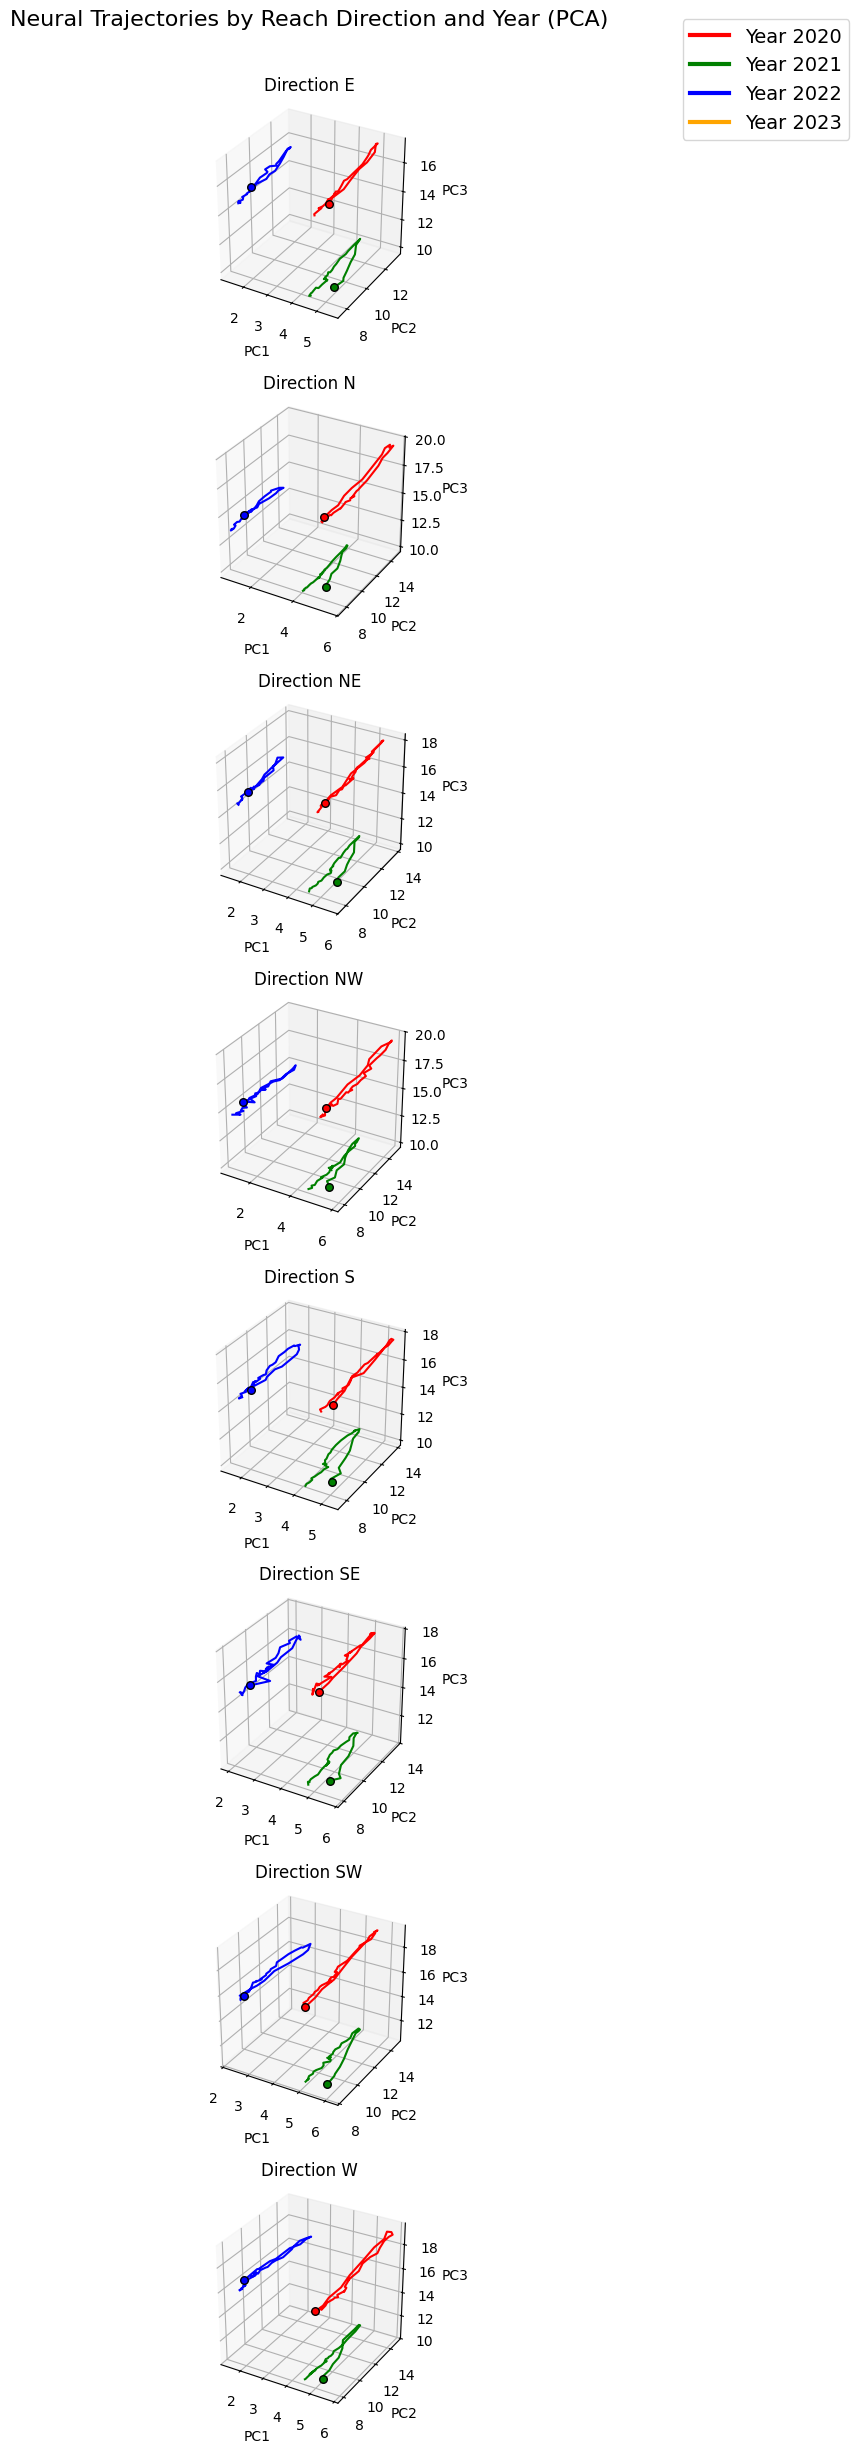

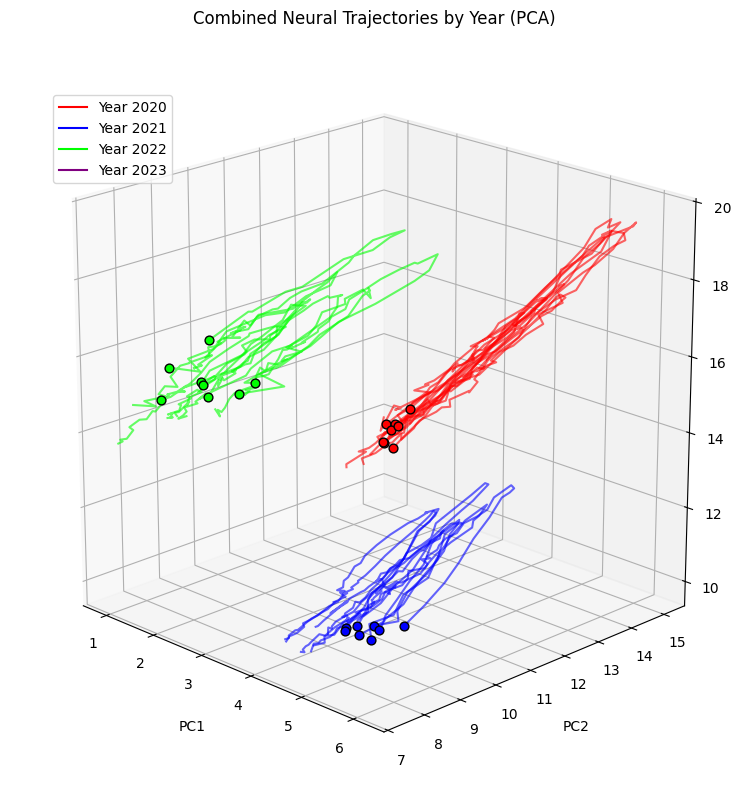

/var/folders/vs/x5my52wn5jv64c7gz3gxk3th0000gn/T/ipykernel_4640/4074127541.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


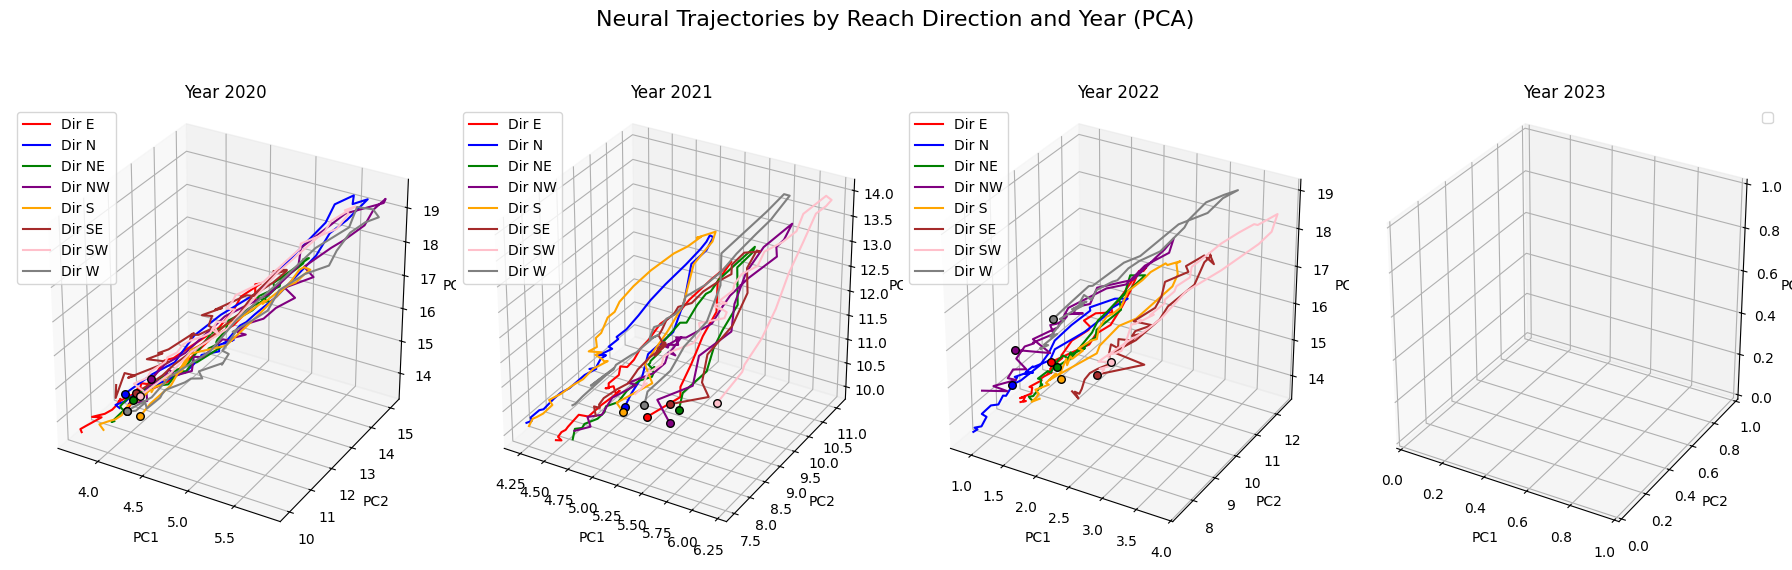

In [59]:
### MAIN SCRIPT ###
from itertools import islice


def pca_of_reach_directions(df_tuning, type_of_data, smoothing=False):

    # define directions
    dir_list, position_map = direction_map(all_directions=False)

    # choose years we want to look at
    time_periods = [2020, 2021, 2022]#, 2023]



    df_yearly = df_tuning.groupby(df_tuning.index.year) 
    # df_monthly = df_tuning.groupby(df_tuning.index.to_period("M"))
    # print(list(df_monthly.groups.keys()))
    # df_monthly = dict(islice(df_monthly, 33))



    # #time_periods = df_monthly.groups.keys()
    # time_periods = list(df_monthly.keys())



    # calculates PCA on all data and split up the trials using that data
    neural_data_for_direction, pca_results = calculate_pca_and_split(df_yearly=df_yearly, time_periods=time_periods, position_map=position_map, type_of_data=type_of_data, jpca=False)

    print("Calculated PCA")

    # Trim and Smooth data (note that data is binned in 20 ms increments, so for example 40 ms smoothing is sigma=2)
    chosen_sigma = 1 if not smoothing else 2
    processed_neural_data_for_direction, kinematics_data = trim_neural_data_at_movement_onset_std_and_smooth(neural_data_for_direction, std_multiplier=2, sigma=chosen_sigma, display_alignment=False)

    print("Trimmed Data")


    # average the PCA data across trials
    averaged_pca_results, averaged_kin_results = average_trial_PCA_data(dir_list=dir_list, kinematics=kinematics_data, processed_neural_data_for_direction=processed_neural_data_for_direction)

    print("Averaged PCA")


    # velocity_pca_results = {
    # year: {direction: compute_velocity(averaged_pca_results[year][direction]) 
    #        for direction in averaged_pca_results[year]}
    # for year in averaged_pca_results
    # }

    # entanglement_results = {
    # year: {direction: compute_entanglement(velocity_pca_results[year][direction], averaged_kin_results[year][direction])
    #        for direction in velocity_pca_results[year]}
    # for year in velocity_pca_results
    # }

    # visualize PCA trajectories
    visualize_trajectories(averaged_pca_results=averaged_pca_results, time_periods=time_periods, ALL_DIRS_ACROSS_YEARS=True, ALL_DIRS_ALL_YEARS_ONE_PLOT=False, ALL_DIRS_GROUPED_BY_YEAR=False)
    visualize_trajectories(averaged_pca_results=averaged_pca_results, time_periods=time_periods, ALL_DIRS_ACROSS_YEARS=False, ALL_DIRS_ALL_YEARS_ONE_PLOT=True, ALL_DIRS_GROUPED_BY_YEAR=False)
    visualize_trajectories(averaged_pca_results=averaged_pca_results, time_periods=time_periods, ALL_DIRS_ACROSS_YEARS=False, ALL_DIRS_ALL_YEARS_ONE_PLOT=False, ALL_DIRS_GROUPED_BY_YEAR=True)
    #visualize_monthly_trajectories(averaged_pca_results=averaged_pca_results, time_periods=time_periods)


    
    #cross_corr_viz(averaged_pca_results)






pca_of_reach_directions(df_tuning=df_tuning, type_of_data="sbps", smoothing=False)
#pca_of_reach_directions(df_tuning=df_tuning, type_of_data="tcfr", smoothing=False)





In [ ]:
import matplotlib.pyplot as plt

years = entanglement_results.keys()
sbp_entanglement = [np.mean(list(entanglement_results[year].values())) for year in years]
tcfr_entanglement = [np.mean(list(entanglement_results_tcfr[year].values())) for year in years]

plt.plot(years, sbp_entanglement, label="SBP Entanglement", marker="o")
plt.plot(years, tcfr_entanglement, label="TCFR Entanglement", marker="s")
plt.xlabel("Year")
plt.ylabel("Entanglement Index")
plt.legend()
plt.title("Entanglement Over Time")
plt.show()